### Microsoft GraphRAG
The codes are based on https://github.com/stephenc222/example-graphrag and modified by Yuan-Tung Chou.

#### Install the pacakges

In [1]:
# %%capture --no-stderr
# %pip install openai networkx cdlib leidenalg python-igraph

In [2]:
import os
from typing import List
from openai import OpenAI
import networkx as nx
import matplotlib.pyplot as plt
from cdlib import algorithms
from tqdm import tqdm

Note: to be able to use all crisp methods, you need to install some additional packages:  {'wurlitzer', 'graph_tool', 'infomap', 'bayanpy'}
Note: to be able to use all crisp methods, you need to install some additional packages:  {'ASLPAw', 'pyclustering'}
Note: to be able to use all crisp methods, you need to install some additional packages:  {'wurlitzer', 'infomap'}


In [3]:
# Init OpenAI Client
OPENAI_API_KEY = "xxx"
client = OpenAI(api_key=OPENAI_API_KEY)

#### Download the txt documents from Google Drive

In [4]:
import requests

def download_file_from_google_drive(file_id, destination):
    URL = "https://docs.google.com/uc?export=download"
    session = requests.Session()
    response = session.get(URL, params={'id': file_id}, stream=True)
    token = get_confirm_token(response)

    if token:
        params = {'id': file_id, 'confirm': token}
        response = session.get(URL, params=params, stream=True)

    save_response_content(response, destination)
    print(f"Downloaded {destination} successfully!")

def get_confirm_token(response):
    for key, value in response.cookies.items():
        if key.startswith('download_warning'):
            return value
    return None

def save_response_content(response, destination):
    CHUNK_SIZE = 32768

    with open(destination, "wb") as f:
        for chunk in response.iter_content(CHUNK_SIZE):
            if chunk:
                f.write(chunk)

doc_id_1 = '1LCWfGre6LusSSZAd2vvcWIHwGVmG3mwa'
doc_id_2 = '1xK_vdN_nmKUYwQKz6X4auRR_CGAXkhuN'
doc_id_3 = '1m0U4pbnAg_kpYAO4thIbpVUV5bg9Qw0_'
download_file_from_google_drive(doc_id_1, "doc1.txt")
download_file_from_google_drive(doc_id_2, "doc2.txt")
download_file_from_google_drive(doc_id_3, "doc3.txt")

Downloaded doc1.txt successfully!
Downloaded doc2.txt successfully!
Downloaded doc3.txt successfully!


In [5]:
# Load the documents
def load_documents(folder_path: str) -> List[str]:
    documents = []
    for filename in tqdm(os.listdir(folder_path), desc="Loading documents"):
        if filename.endswith(".txt") and "doc" in filename:
            with open(os.path.join(folder_path, filename), "r") as file:
                documents.append(file.read())
    return documents


documents = load_documents(folder_path=".")

Loading documents: 100%|██████████| 6/6 [00:00<00:00, 6812.62it/s]


#### 1. Source Documents -> Text Chunks

In [6]:
# 1. Source Documents -> Text Chunks
def split_documents_into_chunks(
    documents: List[str], chunk_size: int = 600, overlap_size: int = 100
):
    chunks = []
    for doc in tqdm(documents, desc="1. Source Documents -> Text Chunks"):
        for i in range(0, len(doc), chunk_size - overlap_size):
            chunks.append(doc[i : i + chunk_size])
    return chunks

#### 2. Text Chunks -> Element Instances

In [7]:
# 2. Text Chunks -> Element Instances
def extract_instances_from_chunks(chunks: List[str]):
    element_instances = []
    for chunk in tqdm(chunks, desc="2. Text Chunks -> Element Instances"):
        response = client.chat.completions.create(
            model="gpt-4o",
            messages=[
                {
                    "role": "system",
                    "content": """
                    Summarize the given text into entities and relationships in a structured format. 
                    Use "->" to represent relationships, after the "Relationships:" word.
                    Make sure the entities in the relationships are from the above Entities section.
                    If a input relationship's entities are not present in the Entities section, please ignore this relationship.
                    If there are several entites in a relationship, please split them into separate relationships, so that each relationship only contains two entities and a relation.
                    Following is a desired output format:

                    Entities:
                    1. Entity 1
                    2. Entity 2
                    3. Entity 3
                    ...

                    Relationships:
                    1. Entity 1 -> leads to -> Entity 2.
                    2. Entity 2 -> follows -> Entity 3.
                    ...
                    """,
                },
                {"role": "user", "content": chunk},
            ],
        )
        element_instance = response.choices[0].message.content
        element_instances.append(element_instance)
    return element_instances

In [8]:
def convert_instances_to_entities_and_relationships(element_instances):
    entities = []
    relationships = []
    for element_instance in element_instances:
        lines = element_instance.split("\n")
        entities_section = False
        relationships_section = False
        
        for line in lines:
            if line.startswith("Entities"):
                entities_section = True
                relationships_section = False
                continue
            elif line.startswith("Relationships"):
                entities_section = False
                relationships_section = True
                continue
            if entities_section and line.strip():
                if line[0].isdigit() and "." in line[1:4]:
                    line = line.split(".", 1)[1].strip()
                entity = line.strip()
                entities.append(entity)
            elif relationships_section and line.strip():
                if line[0].isdigit() and "." in line[1:4]:
                    line = line.split(".", 1)[1].strip()
                if line.endswith("."):
                    line = line[:-1]
                parts = line.split("->")
                if len(parts) == 3:
                    source = parts[0].strip()
                    target = parts[-1].strip()
                    relation = parts[1].strip()
                    relationships.append({"source": source, "target": target, "relation": relation})
                else:
                    print(f"Invalid relationship: {line}")
                    
    return entities, relationships

#### 3. Element Instances -> Element Summaries

In [9]:
# 3. Element Instances -> Element Summaries
def summarize_elements(entities, relationships):
    element_summaries = {}
    for entity in tqdm(entities, desc="3. Element Instances -> Element Summaries"):
        relevant_relationships = [r for r in relationships if r["source"] == entity or r["target"] == entity]
        response = client.chat.completions.create(
            model="gpt-4o",
            messages=[
                {
                    "role": "system",
                    "content": """
                    Summarize the given entity and its relationships with other entities into a descriptive summary of this entity.
                    """,
                },
                {"role": "user", "content": f"""
                    Entity: {entity}  
                    Relationships: 
                    {', '.join([f"{r['source']} -> {r['relation']} -> {r['target']}" for r in relevant_relationships])}
                    """},
            ],
        )
        summary = response.choices[0].message.content
        element_summaries[entity] = summary
    return element_summaries

#### 4. Element Summaries -> Graph Communities

In [10]:
# 4. Element Summaries -> Graph Communities
def build_graph_from_instances(entities, relationships):
    G = nx.Graph()
    for entity in entities:
        G.add_node(entity)
    for relation in relationships:
        G.add_edge(relation["source"], relation["target"], label=relation["relation"])
    return G


def visualize_graph(G):
    # Set up the figure and axis
    plt.figure(figsize=(12, 10))  # Increase the figure size if needed

    # Adjust node spacing by setting the 'k' parameter in spring_layout
    pos = nx.spring_layout(
        G, k=0.9
    )  # Increase 'k' to control the spacing between nodes (default is 0.1)

    # Draw the nodes
    nx.draw_networkx_nodes(G, pos, node_color="lightblue", node_size=1000)

    # Draw the edges
    nx.draw_networkx_edges(G, pos, edgelist=G.edges(), width=2)

    # Draw the labels for the nodes
    nx.draw_networkx_labels(G, pos, font_size=6, font_family="sans-serif")

    # Get edge labels from the graph and draw them
    edge_labels = nx.get_edge_attributes(G, "label")
    nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_color="red")

    # Display the graph
    plt.title("Knowledge Graph Visualization")
    plt.axis("off")  # Hide the axis
    plt.show()


def detect_communities(graph):
    communities = []
    index = 0
    for component in tqdm(nx.connected_components(graph), desc="Detecting Communities"):
        subgraph = graph.subgraph(component)
        if len(subgraph.nodes) > 1:  # Leiden algorithm requires at least 2 nodes
            try:
                sub_communities = algorithms.leiden(subgraph)
                for community in sub_communities.communities:
                    communities.append(list(community))
            except Exception as e:
                # print(f"Error processing community {index}: {e}")
                communities.append(list(subgraph.nodes))
        else:
            communities.append(list(subgraph.nodes))
        index += 1
    return communities

#### 5. Graph Communities -> Community Summaries

In [11]:
# 5. Graph Communities -> Community Summaries
def summarize_communities(communities, graph, element_summaries):
    community_summaries = []
    for community in tqdm(
        communities, desc="5. Graph Communities -> Community Summaries"
    ):
        subgraph = graph.subgraph(community)
        nodes = list(subgraph.nodes)
        description = ""
        for node in nodes:
            if node in element_summaries:
                description += f"{node}: {element_summaries[node]}\n"

        response = client.chat.completions.create(
            model="gpt-4",
            messages=[
                {
                    "role": "system",
                    "content": "Summarize the following entity summaries in the community into a descriptive summary of this community.",
                },
                {"role": "user", "content": description},
            ],
        )
        summary = response.choices[0].message.content.strip()
        community_summaries.append(summary)
    return community_summaries

#### 6. Community Summaries -> Community Answers -> Global Answer

In [12]:
# 6. Community Summaries -> Community Answers -> Global Answer
def generate_answers_from_communities(community_summaries, query):
    intermediate_answers = []
    for summary in tqdm(
        community_summaries,
        desc="6. Community Summaries -> Community Answers -> Global Answer",
    ):
        response = client.chat.completions.create(
            model="gpt-4o",
            messages=[
                {
                    "role": "system",
                    "content": "Answer the following query based on the provided summary.",
                },
                {"role": "user", "content": f"Query: {query} Summary: {summary}"},
            ],
        )
        intermediate_answers.append(response.choices[0].message.content)

    final_response = client.chat.completions.create(
        model="gpt-4o",
        messages=[
            {
                "role": "system",
                "content": "Combine these answers into a final, concise response.",
            },
            {
                "role": "user",
                "content": f"Intermediate answers: {intermediate_answers}",
            },
        ],
    )
    final_answer = final_response.choices[0].message.content
    return final_answer

In [13]:
# Putting all the process together
def graph_rag_pipeline(
    query: str, documents: List[str], chunk_size: int = 600, overlap_size: int = 100
):
    # 1. Source Documents -> Text Chunks
    chunks = split_documents_into_chunks(
        documents=documents, chunk_size=chunk_size, overlap_size=overlap_size
    )

    # 2. Text Chunks -> Element Instances
    element_instances = extract_instances_from_chunks(chunks)
    entities, relationships = convert_instances_to_entities_and_relationships(element_instances)

    # 3. Element Instances → Element Summaries
    element_summaries = summarize_elements(entities, relationships)

    # 4. Element Summaries -> Graph Communities
    graph = build_graph_from_instances(entities, relationships)
    visualize_graph(G=graph)
    communities = detect_communities(graph)

    # 5. Graph Communities -> Community Summaries
    community_summaries = summarize_communities(communities, graph, element_summaries)

    # 6. Community Summaries -> Community Answers -> Global Answer
    final_answer = generate_answers_from_communities(community_summaries, query)

    return final_answer

3. Element Instances -> Element Summaries: 100%|██████████| 304/304 [24:26<00:00,  4.82s/it]


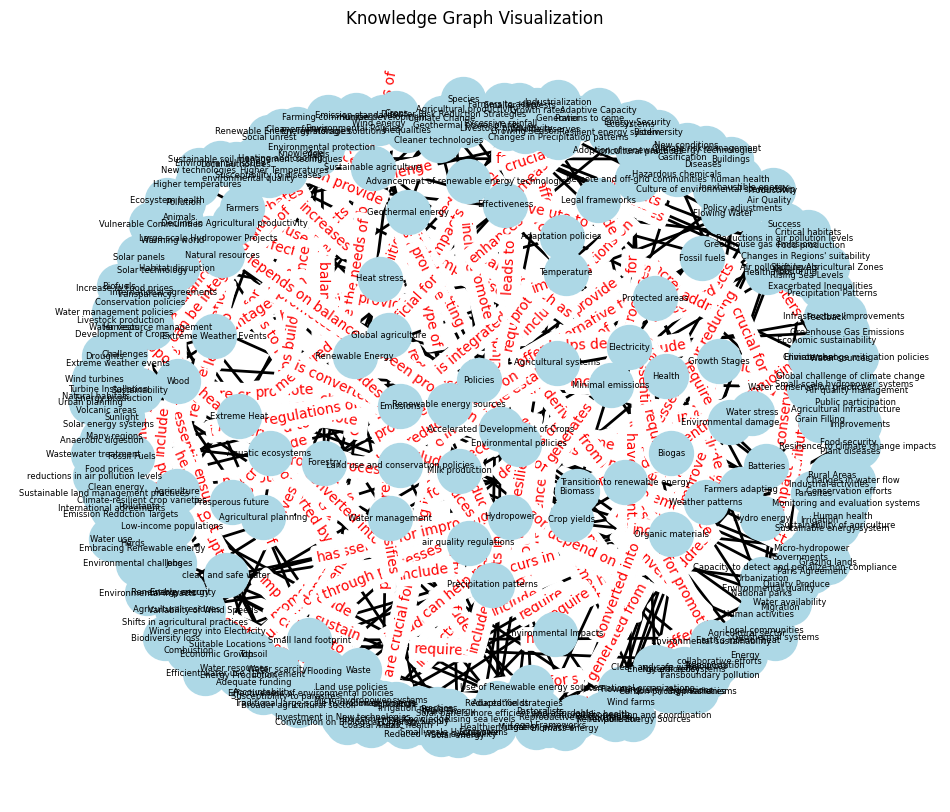

Detecting Communities: 60it [00:00, 3813.18it/s]
5. Graph Communities -> Community Summaries: 100%|██████████| 71/71 [10:38<00:00,  8.99s/it]
6. Community Summaries -> Community Answers -> Global Answer: 100%|██████████| 71/71 [05:12<00:00,  4.40s/it]


query: What are the main themes in these documents?
answer:
The documents collectively emphasize themes of sustainability, environmental protection, and renewable energy, highlighting areas such as sustainable energy generation, environmental impact, renewable energy technologies, and climate change mitigation. Key environmental challenges include air and water pollution, biodiversity loss, and ecosystem dynamics. Economic aspects are also addressed, such as the role of renewable energy in economic growth, technological innovations, and equitable distribution of resources. Agriculture and food security, disaster risk reduction, and public health intersect with these themes, underscoring the need for integrated, cross-sectoral policies and collaborations at local, national, and international levels. The importance of legal frameworks, stakeholder involvement, transparency, and accountability are emphasized for effective governance and policy implementation to achieve sustainable develop

In [14]:
query = "What are the main themes in these documents?"
answer = graph_rag_pipeline(query=query, documents=documents)
print("query:", query)
print("answer:")
print(answer)